<a href="https://colab.research.google.com/github/Tachapol/Movie-Recommendation-Systems/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install fuzzywuzzy
from fuzzywuzzy import process

In [ ]:
ratings = pd.read_csv('/content/ratings.csv')

In [ ]:
movies = pd.read_csv('/content/movies.csv')

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Step 3: Exploratory Data Analysis

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


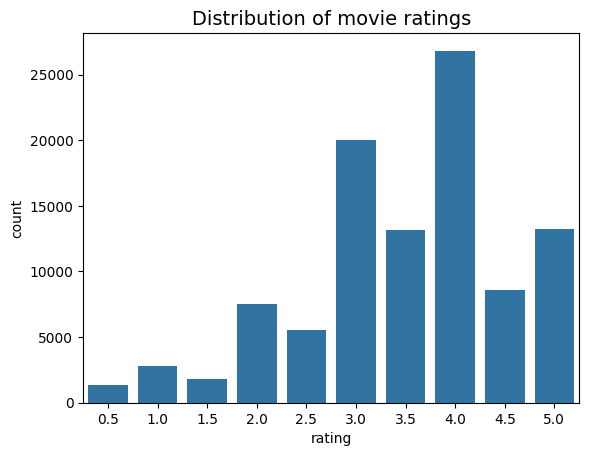

In [ ]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [ ]:
mean_ratings = ratings.groupby('userId')[['rating']].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: rating    3.66
dtype: float64.


### Which movies are most frequently rated?

In [ ]:
ratings['movieId'].value_counts()

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
86279,1
86922,1
5962,1


In [ ]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [ ]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] ==  lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C + ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [ ]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

In [ ]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else x)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [ ]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


<ipython-input-29-9ba33bc67d34>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values('count', ascending=False), palette='viridis')


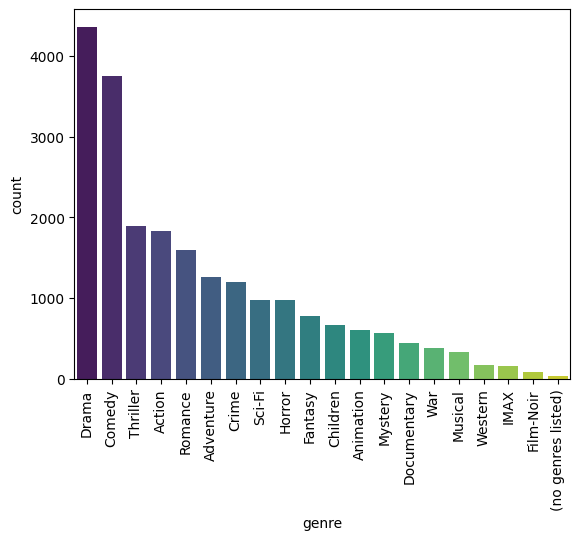

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values('count', ascending=False), palette='viridis')
plt.xticks(rotation=90)
plt.show()

The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    df = df.dropna(subset=['movieId'])
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

In [ ]:
X.shape

(610, 9724)

Our `X` matrix contains 117391 users and 61445 movies.

In [ ]:
n_total = X.shape[0] * X.shape[1]  # Total number of elements in the matrix
n_ratings = X.nnz  # Number of non-zero elements
density = n_ratings / n_total  # Proportion of non-zero elements
sparsity = 1 - density  # Proportion of zero elements

print(f"Matrix density: {round(density * 100, 2)}%")
print(f"Matrix sparsity: {round(sparsity * 100, 2)}%")

Matrix density: 1.7%
Matrix sparsity: 98.3%


In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


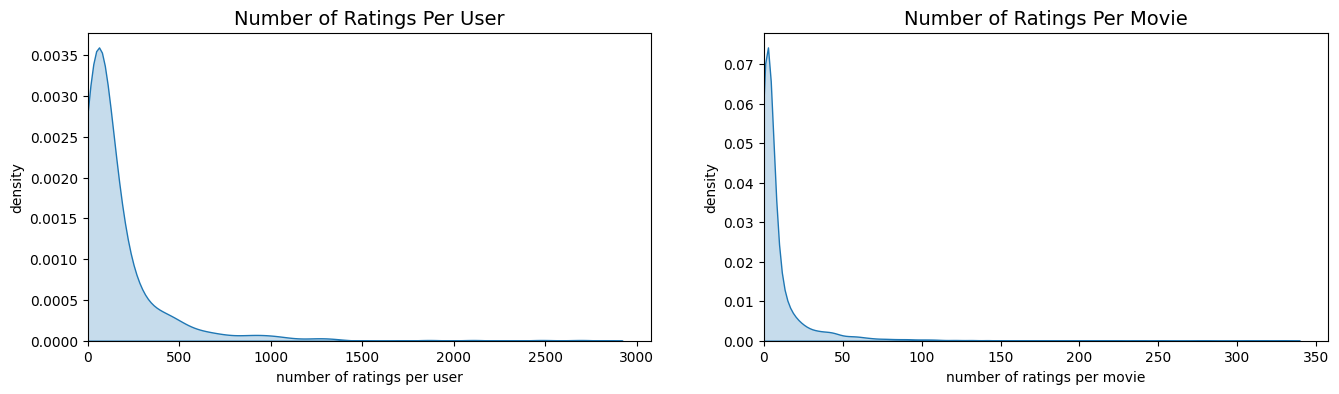

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 1
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title} we recommend :")
for i in similar_movies:
  print(movie_titles[i])

Because you watched Toy Story (1995) we recommend :
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


In [ ]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [ ]:
genres = set(g for gs in movies['genres'] for g in gs)

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [ ]:
movie_genres.head()

,Children,Fantasy,Musical,Drama,Film-Noir,Western,Action,Thriller,War,Animation,Sci-Fi,Comedy,Mystery,IMAX,Romance,Adventure,Documentary,(no genres listed),Crime,Horror
0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [ ]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [ ]:
title = movie_finder('Juminji')
title

'Jumanji (1995)'

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
sim_scores

[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [ ]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('Juminji', 10)

Because you watched Jumanji (1995):
53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, n_iter=10 )
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [ ]:
def recommendation(title_string):
  title = movie_finder(title_string)
  movie_idx = dict(zip(movies['title'], list(movies.index)))
  idx = movie_idx[title]
  similar_movies = find_similar_movies(idx, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=11)
  movie_title = movie_titles[idx]
  print(f"Because you watched {title}:")
  for i in similar_movies:
    print(movie_titles[i])

In [ ]:
recommendation('Jumanji')

Because you watched Jumanji (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
Babe (1995)
